## loading libraries and dataset...

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import random, os
from sklearn.linear_model import LogisticRegression

# Loading and re-sorting for temporal order...
df = pd.read_csv("C:/Users/LATITUDE E7470/Desktop/ajcodes/research/fatigueanalysis1/eye_features.csv")
df = df.sort_values(by='image_name').reset_index(drop=True)

# Feature engineering
df['ear_rolling_mean'] = df['ear'].rolling(window=5, min_periods=1).mean()
df['ear_delta'] = df['ear'].diff().fillna(0)
df['eye_closed'] = df['ear'].apply(lambda x: 1 if x < 0.21 else 0)

# Choosing features for LSTM input
features = df[['ear', 'ear_rolling_mean', 'ear_delta', 'eye_closed']].values
labels = df['label'].values

# Generating sequences...
SEQ_LEN = 10
X_seq, y_seq = [], []

for i in range(len(features) - SEQ_LEN):
    X_seq.append(features[i:i+SEQ_LEN])
    y_seq.append(labels[i+SEQ_LEN - 1])  # use label of last frame

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print("Shape of sequence data:", X_seq.shape)  # (samples, time_steps, features)


Shape of sequence data: (65919, 10, 4)


## splitting into train/test set...

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.3, random_state=42, stratify=y_seq
)

## coding for LSTM Model...

In [11]:
model = Sequential([
    Input(shape=(SEQ_LEN, X_seq.shape[2])),  # Defining input shape...
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5476 - loss: 0.6867 - val_accuracy: 0.5715 - val_loss: 0.6672
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5714 - loss: 0.6696 - val_accuracy: 0.5877 - val_loss: 0.6621
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5789 - loss: 0.6657 - val_accuracy: 0.5844 - val_loss: 0.6580
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5885 - loss: 0.6611 - val_accuracy: 0.5980 - val_loss: 0.6517
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6052 - loss: 0.6536 - val_accuracy: 0.6218 - val_loss: 0.6417
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6137 - loss: 0.6454 - val_accuracy: 0.6302 - val_loss: 0.6356
Epoch 7/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6184 - loss: 0.6415 - val_accuracy: 0.6363 - val_loss: 0.6349
Epoch 8/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6228 - loss: 0.6394 - val_accuracy: 0

## evaluating the LSTM Model....

In [12]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

618/618 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
[[3241 5728]
 [1337 9470]]
              precision    recall  f1-score   support

           0       0.71      0.36      0.48      8969
           1       0.62      0.88      0.73     10807

    accuracy                           0.64     19776
   macro avg       0.67      0.62      0.60     19776
weighted avg       0.66      0.64      0.62     19776



## implementing SHAP for LSTM...

  0%|          | 0/20 [00:00<?, ?it/s]

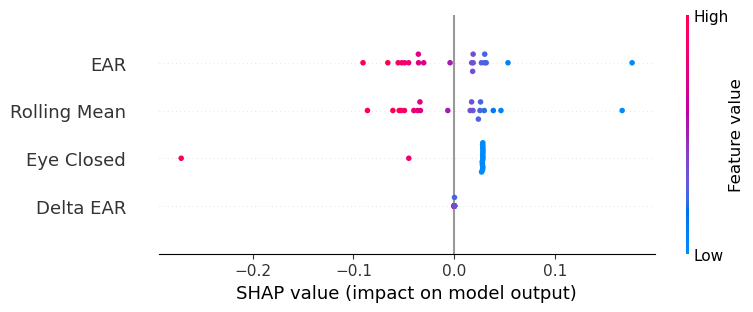

In [13]:
# Pooling mr LSTM input into 2D (mean across timesteps)...
X_train_flat = X_train.mean(axis=1)
X_test_flat = X_test.mean(axis=1)

# Training a simple surrogate model (e.g., logistic regression)...
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_flat, y_train)

# Explaining the surrogate...
background = X_train_flat[np.random.choice(X_train_flat.shape[0], 100, replace=False)]
explainer = shap.KernelExplainer(lr_model.predict_proba, background) 

# Explain only for class index 1 (drowsy class)
full_explanation_object = explainer(X_test_flat[:20])

shap_values_for_class1 = full_explanation_object.values[:, :, 1]

base_values_for_class1 = full_explanation_object.base_values[:, 1]
avg_base_value_for_class1 = np.mean(base_values_for_class1) # Calculate the average base value

shap_explanation_class_1 = shap.Explanation(
    values=shap_values_for_class1,
    base_values=avg_base_value_for_class1, # Use the average base value for the plot
    data=X_test_flat[:20], # Original feature values for the explained instances
    feature_names=['EAR', 'Rolling Mean', 'Delta EAR', 'Eye Closed']
)

# Plot SHAP for class 1
shap.plots.beeswarm(shap_explanation_class_1)